In [1]:
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from collections import Counter
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

In [2]:
# ----------------------------
# HELPER FUNCTIONS
# ----------------------------
#decided to remove some features( min and max)
#because the model tended to focus on them and ignore the hr and rr
FEATURE_COLUMNS = [
   'ax_mean','ax_std','ax_median',
   'ay_mean','ay_std','ay_median',
  'az_mean','az_std','az_median',
  'gx_mean','gx_std','gx_median',
   'gy_mean','gy_std','gy_median',
    'gz_mean','gz_std','gz_median',
    'average','rr_ms','HRR_percent'
]
TARGET_COL = "fatigue_level"
RANDOM_STATE = 42
WIN = 30
OVERLAP = 0.3  # 30% overlap
OVERLAP_ROWS = int(WIN * OVERLAP)

def load_clean_scale_file(path, features=FEATURE_COLUMNS, target_col=TARGET_COL, win=WIN, overlap=OVERLAP_ROWS):
    """
    Load a single CSV file, scale, and create sliding windows with overlap.
    Each file is scaled INDEPENDENTLY to prevent data leakage.

    Returns:
        X_windows_scaled: (n_windows, win, n_features) - scaled windows
        y_windows: (n_windows,) - window labels
        n_original_rows: int - original row count
    """

    # 1. Load data
    df = pd.read_csv(path)

    # Check required columns
    required_cols = features + [target_col]
    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in {path}: {missing_cols}")

    # 2. Extract features and target
    X_raw = df[features].values
    y_raw = df[target_col].values
    n_original_rows = len(X_raw)

    print(f"  Raw data: {n_original_rows} rows")

    # 3. Scale this file INDEPENDENTLY using RobustScaler
    scaler = RobustScaler(quantile_range=(25, 75))  # IQR-based, outlier-resistant
    X_scaled = scaler.fit_transform(X_raw)

    # 4. Create SLIDING windows with overlap from SCALED data
    step = win - overlap  # Step size for sliding window
    n_full_windows = max(0, (len(X_scaled) - win) // step + 1)

    if n_full_windows == 0:
        print(f"  WARNING: Not enough data for {win}-second windows with {overlap} overlap")
        return np.zeros((0, win, len(features))), np.zeros((0,), dtype=int), n_original_rows

    # Create sliding windows
    X_windowed = np.array([X_scaled[i:i+win] for i in range(0, len(X_scaled) - win + 1, step)])

    # 5. Assign window labels (majority vote)
    y_windowed = []
    for i in range(0, len(y_raw) - win + 1, step):
        window_labels = y_raw[i:i+win]
        unique, counts = np.unique(window_labels, return_counts=True)
        y_windowed.append(int(unique[np.argmax(counts)]))
    y_windowed = np.array(y_windowed, dtype=int)

    print(f"  Created {n_full_windows} windows with {overlap} rows overlap")
    print(f"  Step size: {step} rows (overlap: {overlap/win*100:.0f}%)")
    print(f"  Scaled data stats - Mean: {X_scaled.mean():.3f}, Std: {X_scaled.std():.3f}")
    print(f"  Value range: [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")

    return X_windowed, y_windowed, n_original_rows


def combine_and_split_data(all_windows, all_labels, test_size=0.2, random_state=RANDOM_STATE):
    """
    Combine windows from all files, shuffle, and split into train/validation.

    Returns:
        X_train, X_val, y_train, y_val
    """

    # Combine all windows
    X_all = np.vstack(all_windows)
    y_all = np.concatenate(all_labels)

    print(f"\nCombined dataset:")
    print(f"  Total windows: {X_all.shape[0]}")
    print(f"  Window shape: {X_all.shape[1:]}")
    print(f"  Features: {X_all.shape[2]}")
    print(f"  Class distribution: {Counter(y_all)}")

    # Shuffle all windows
    rng = np.random.default_rng(random_state)
    shuffle_idx = rng.permutation(len(y_all))
    X_all = X_all[shuffle_idx]
    y_all = y_all[shuffle_idx]

    # Stratified train/validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_all, y_all,
        test_size=test_size,
        random_state=random_state,
        stratify=y_all
    )

    print(f"\nSplit results:")
    print(f"  Training windows: {X_train.shape[0]}")
    print(f"  Validation windows: {X_val.shape[0]}")
    print(f"  Train class distribution: {Counter(y_train)}")
    print(f"  Val class distribution: {Counter(y_val)}")

    # Final data quality check
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    print(f"\nTraining data quality:")
    print(f"  Mean: {X_train_flat.mean():.6f} (should be ~0)")
    print(f"  Std: {X_train_flat.std():.6f} (should be ~1)")
    print(f"  Range: [{X_train_flat.min():.3f}, {X_train_flat.max():.3f}]")

    # Verify no extreme values
    if np.abs(X_train_flat.mean()) > 0.1:
        print(f"  ⚠️  Warning: Mean deviates from 0")
    if np.abs(X_train_flat.std() - 1.0) > 0.3:
        print(f"  ⚠️  Warning: Std dev deviates from 1")

    return X_train, X_val, y_train, y_val


# Visualization function to understand the sliding windows
def visualize_sliding_windows(X_sample, win=WIN, overlap=OVERLAP_ROWS):
    """
    Visualize how sliding windows work
    """
    n_samples = len(X_sample)
    step = win - overlap
    n_windows = max(0, (n_samples - win) // step + 1)

    print(f"\nSliding Window Visualization:")
    print(f"Total samples: {n_samples}")
    print(f"Window size: {win}")
    print(f"Overlap: {overlap} rows ({overlap/win*100:.0f}%)")
    print(f"Step size: {step} rows")
    print(f"Number of windows: {n_windows}")

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # 1. Window positions
    axes[0, 0].plot(range(n_samples), np.ones(n_samples), 'b-', alpha=0.3, label='Data')
    for i in range(0, n_samples - win + 1, step):
        axes[0, 0].axvspan(i, i+win, alpha=0.2, color='red')
    axes[0, 0].set_xlabel('Sample index')
    axes[0, 0].set_title(f'Sliding Windows (WIN={win}, overlap={overlap})')
    axes[0, 0].legend(['Data', 'Windows'])
    axes[0, 0].grid(True, alpha=0.3)

    # 2. First few windows
    if n_windows > 0:
        axes[0, 1].imshow(X_sample[:win*3].T, aspect='auto', cmap='viridis')
        axes[0, 1].set_xlabel('Sample index')
        axes[0, 1].set_ylabel('Feature')
        axes[0, 1].set_title('First 3 Windows of Data')
        axes[0, 1].axvline(x=win, color='red', linestyle='--', linewidth=2)
        axes[0, 1].axvline(x=win*2, color='red', linestyle='--', linewidth=2)
        axes[0, 1].text(win/2, -1, 'Window 1', ha='center', va='top')
        axes[0, 1].text(win*1.5, -1, 'Window 2', ha='center', va='top')
        axes[0, 1].text(win*2.5, -1, 'Window 3', ha='center', va='top')

    # 3. Overlap visualization
    if n_windows >= 2:
        window1 = X_sample[:win]
        window2 = X_sample[step:step+win]

        axes[1, 0].plot(range(win), window1.mean(axis=1), 'b-', label='Window 1', linewidth=2)
        axes[1, 0].plot(range(win), window2.mean(axis=1), 'r-', label='Window 2', linewidth=2, alpha=0.7)
        axes[1, 0].fill_between(range(overlap),
                              window1[:overlap].mean(axis=1).min(),
                              window1[:overlap].mean(axis=1).max(),
                              alpha=0.2, color='gray', label=f'Overlap ({overlap} samples)')
        axes[1, 0].set_xlabel('Position in window')
        axes[1, 0].set_ylabel('Mean feature value')
        axes[1, 0].set_title(f'Overlap between consecutive windows')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # 4. Statistics
    axes[1, 1].bar(['Non-overlapping', '50% Overlap'],
                  [n_samples // win, n_windows])
    axes[1, 1].set_ylabel('Number of windows')
    axes[1, 1].set_title('Window Count Comparison')
    axes[1, 1].text(0, (n_samples // win) * 1.05, f'{n_samples // win} windows', ha='center')
    axes[1, 1].text(1, n_windows * 1.05, f'{n_windows} windows', ha='center')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return n_windows


# Example usage of the visualization
def test_sliding_windows():
    """
    Test the sliding window functionality
    """
    print("="*60)
    print("TESTING SLIDING WINDOWS")
    print("="*60)

    # Create synthetic data for testing
    n_samples = 100
    n_features = len(FEATURE_COLUMNS)
    X_test = np.random.randn(n_samples, n_features)
    y_test = np.random.choice([0, 1, 2, 3], size=n_samples)

    print(f"\nTest data: {n_samples} samples, {n_features} features")

    # Test with different overlap values
    for overlap_pct in [0, 0.25, 0.5, 0.75]:
        overlap_rows = int(WIN * overlap_pct)
        step = WIN - overlap_rows
        n_windows = max(0, (n_samples - WIN) // step + 1)

        print(f"\nOverlap {overlap_pct*100:.0f}% ({overlap_rows} rows):")
        print(f"  Step size: {step} rows")
        print(f"  Number of windows: {n_windows}")
        print(f"  Data utilization: {n_windows * WIN / n_samples:.1f}x more data points")

    # Show visualization
    visualize_sliding_windows(X_test)


# Data loading function that works with the new sliding windows
def load_data_with_sliding_windows():
    """
    Load all data with sliding windows
    """
    DATA_FILES = [
        ("imu_agg_hr_joined_level0.csv", "level0"),
        ("imu_agg_hr_joined_level1.csv", "level1"),
        ("imu_agg_hr_joined_level2.csv", "level2"),
        ("imu_agg_hr_joined_level3.csv", "level3"),
    ]

    print("="*60)
    print("DATA LOADING WITH SLIDING WINDOWS (50% OVERLAP)")
    print("="*60)

    all_windows = []
    all_labels = []
    file_stats = []

    for file_path, file_tag in DATA_FILES:
        print(f"\nProcessing: {file_path} ({file_tag})")
        print("-" * 40)

        try:
            # Load, scale, and create sliding windows
            X_windows, y_windows, n_rows = load_clean_scale_file(
                file_path,
                features=FEATURE_COLUMNS,
                target_col=TARGET_COL,
                win=WIN,
                overlap=OVERLAP_ROWS
            )

            if len(X_windows) > 0:
                all_windows.append(X_windows)
                all_labels.append(y_windows)

                file_stats.append({
                    'file': file_path,
                    'tag': file_tag,
                    'original_rows': n_rows,
                    'windows_created': len(X_windows),
                    'window_increase': f"{len(X_windows)/(n_rows//WIN if n_rows//WIN>0 else 1):.1f}x",
                    'class_distribution': Counter(y_windows)
                })

                print(f"✓ Successfully processed")
            else:
                print(f"✗ Skipped - not enough data for windows")

        except Exception as e:
            print(f"✗ Error processing {file_path}: {e}")
            continue

    print(f"\n{'='*60}")
    print("PROCESSING SUMMARY")
    print('='*60)
    print(f"Total files processed: {len(file_stats)}")
    print(f"Window configuration: WIN={WIN}, Overlap={OVERLAP_ROWS} rows ({OVERLAP*100:.0f}%)")

    for stat in file_stats:
        print(f"\n{stat['file']}:")
        print(f"  Original rows: {stat['original_rows']}")
        print(f"  Windows created: {stat['windows_created']}")
        print(f"  Window increase: {stat['window_increase']} vs non-overlapping")
        print(f"  Class distribution: {stat['class_distribution']}")

    # Check if we have any data
    if len(all_windows) == 0:
        raise RuntimeError("No windows created from any file!")

    # Combine and split the data
    X_train, X_val, y_train, y_val = combine_and_split_data(all_windows, all_labels)

    return X_train, X_val, y_train, y_val, file_stats

In [4]:
# ----------------------------
# DATA LOADING AND PREPROCESSING
# ----------------------------
DATA_FILES = [
    "imu_agg_hr_joined_level0.csv",
    "imu_agg_hr_joined_level1.csv",
    "imu_agg_hr_joined_level2.csv",
    "imu_agg_hr_joined_level3.csv",
]

print("="*60)
print("DATA LOADING AND PREPROCESSING")
print("="*60)

all_windows = []
all_labels = []
file_stats = []

for file_path in DATA_FILES:
    # Extract tag from filename
    if "level0" in file_path:
        file_tag = "level0"
    elif "level1" in file_path:
        file_tag = "level1"
    elif "level2" in file_path:
        file_tag = "level2"
    elif "level3" in file_path:
        file_tag = "level3"
    else:
        file_tag = "unknown"

    print(f"\nProcessing: {file_path} ({file_tag})")
    print("-" * 40)

    try:
        # Load, scale, and window this file (outliers already handled)
        X_windows, y_windows, n_rows = load_clean_scale_file(
            file_path,
            features=FEATURE_COLUMNS,
            target_col=TARGET_COL,
            win=WIN
        )

        if len(X_windows) > 0:
            all_windows.append(X_windows)
            all_labels.append(y_windows)

            file_stats.append({
                'file': file_path,
                'tag': file_tag,
                'original_rows': n_rows,
                'windows_created': len(X_windows),
                'class_distribution': Counter(y_windows)
            })

            print(f"✓ Successfully processed")
        else:
            print(f"✗ Skipped - not enough data for windows")

    except Exception as e:
        print(f"✗ Error processing {file_path}: {e}")
        continue

print(f"\n{'='*60}")
print("PROCESSING SUMMARY")
print('='*60)
print(f"Total files processed: {len(file_stats)}")

for stat in file_stats:
    print(f"\n{stat['file']}:")
    print(f"  Original rows: {stat['original_rows']}")
    print(f"  Windows created: {stat['windows_created']}")
    print(f"  Class distribution: {stat['class_distribution']}")

# Check if we have any data
if len(all_windows) == 0:
    raise RuntimeError("No windows created from any file!")

# Combine and split the data
X_train, X_val, y_train, y_val = combine_and_split_data(all_windows, all_labels)

DATA LOADING AND PREPROCESSING

Processing: imu_agg_hr_joined_level0.csv (level0)
----------------------------------------
  Raw data: 923 rows
  Created 43 windows with 9 rows overlap
  Step size: 21 rows (overlap: 30%)
  Scaled data stats - Mean: 0.138, Std: 1.593
  Value range: [-34.400, 54.192]
✓ Successfully processed

Processing: imu_agg_hr_joined_level1.csv (level1)
----------------------------------------
  Raw data: 1654 rows
  Created 78 windows with 9 rows overlap
  Step size: 21 rows (overlap: 30%)
  Scaled data stats - Mean: 0.009, Std: 0.835
  Value range: [-5.324, 5.553]
✓ Successfully processed

Processing: imu_agg_hr_joined_level2.csv (level2)
----------------------------------------
  Raw data: 904 rows
  Created 42 windows with 9 rows overlap
  Step size: 21 rows (overlap: 30%)
  Scaled data stats - Mean: 0.107, Std: 0.968
  Value range: [-4.275, 29.596]
✓ Successfully processed

Processing: imu_agg_hr_joined_level3.csv (level3)
--------------------------------------

In [5]:
def check_data_quality(X_train_s, X_val, feature_names):
    """Comprehensive data quality check"""

    print("="*60)
    print("DATA QUALITY CHECK")
    print("="*60)

    # 1. Check for NaN/Inf values
    print(f"\n1. NaN/Inf values:")
    print(f"   Training NaN: {np.isnan(X_train_s).sum()}")
    print(f"   Validation NaN: {np.isnan(X_val).sum()}")
    print(f"   Training Inf: {np.isinf(X_train_s).sum()}")
    print(f"   Validation Inf: {np.isinf(X_val).sum()}")

    # 2. Check statistics
    print(f"\n2. Data statistics (training set):")
    X_flat = X_train_s.reshape(-1, len(feature_names))

    for i, feat in enumerate(feature_names):
        feat_vals = X_flat[:, i]
        print(f"   {feat:15s}: mean={feat_vals.mean():8.4f}, "
              f"std={feat_vals.std():8.4f}, "
              f"min={feat_vals.min():8.4f}, "
              f"max={feat_vals.max():8.4f}")

    # 3. Check for outliers (using IQR)
    print(f"\n3. Outlier detection (IQR method):")
    for i, feat in enumerate(feature_names):
        feat_vals = X_flat[:, i]
        Q1 = np.percentile(feat_vals, 25)
        Q3 = np.percentile(feat_vals, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 2.5 * IQR
        upper_bound = Q3 + 2.5 * IQR
        outliers = np.sum((feat_vals < lower_bound) | (feat_vals > upper_bound))

        print(f"   {feat:15s}: {outliers} outliers "
                  f"({outliers/len(feat_vals)*100:.1f}%)")

    return X_flat

# Run the check
X_flat_train = check_data_quality(X_train, X_val, FEATURE_COLUMNS)

DATA QUALITY CHECK

1. NaN/Inf values:
   Training NaN: 0
   Validation NaN: 0
   Training Inf: 0
   Validation Inf: 0

2. Data statistics (training set):
   ax_mean        : mean=  0.0013, std=  0.8750, min= -3.8478, max=  8.3069
   ax_std         : mean=  0.2301, std=  1.3945, min= -1.2390, max= 54.0541
   ax_median      : mean= -0.1066, std=  1.0800, min= -5.3237, max=  7.2732
   ay_mean        : mean= -0.0169, std=  1.0660, min= -5.6474, max=  6.2556
   ay_std         : mean=  0.1267, std=  1.0486, min= -1.0900, max= 21.5770
   ay_median      : mean= -0.0537, std=  0.8755, min= -4.2755, max=  3.0089
   az_mean        : mean=  0.0309, std=  0.6939, min= -3.5884, max=  2.9344
   az_std         : mean=  0.2097, std=  1.2252, min= -1.3868, max= 27.7344
   az_median      : mean=  0.0647, std=  0.6504, min= -3.8312, max=  2.8714
   gx_mean        : mean=  0.0182, std=  1.1232, min=-28.2767, max= 13.2469
   gx_std         : mean=  0.2553, std=  1.0832, min= -1.0669, max= 24.5087
   gx_med

In [6]:
# ----------------------------
# MODEL DEFINITION (IDENTICAL TO BLOC 6)
# ----------------------------
print("\n" + "="*60)
print("MODEL DEFINITION")
print("="*60)

WIN = 30
n_features = 21

num_classes = len(np.unique(y_train))

# One-hot encoding
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = tf.keras.utils.to_categorical(y_val, num_classes)

# Class weights
counts = Counter(y_train.tolist())
maxc = max(counts.values())
class_weight = {i: float(maxc / counts.get(i, 1)) for i in range(num_classes)}
print(f"Class weights: {class_weight}")

# --------------------------------------------------
# Model: Conv1D + BiLSTM (temporal) + Conv2D (spatial)
# --------------------------------------------------
inp = layers.Input(shape=(WIN, n_features))

# ===== Temporal branch =====
b1 = layers.Conv1D(32, kernel_size=5, padding='same', activation='relu')(inp)
b1 = layers.LayerNormalization()(b1)
b1 = layers.SpatialDropout1D(0.15)(b1)

b1 = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(b1)
b1 = layers.LayerNormalization()(b1)
b1 = layers.MaxPool1D(2)(b1)

b1 = layers.Bidirectional(
    layers.LSTM(64, dropout=0.15)
)(b1)

# ===== Spatial branch (features × time) =====
b2 = layers.Permute((2, 1))(inp)                 # (None, features, WIN)
b2 = layers.Reshape((n_features, WIN, 1))(b2)   # (None, features, WIN, 1)

b2 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(b2)
b2 = layers.LayerNormalization()(b2)

b2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(b2)
b2 = layers.LayerNormalization()(b2)

b2 = layers.MaxPool2D((2, 2))(b2)
b2 = layers.GlobalAveragePooling2D()(b2)

# ===== Fusion + classifier =====
x = layers.Concatenate()([b1, b2])
x = layers.Dense(
    96,
    activation='relu',
    kernel_regularizer=regularizers.l2(1e-5)
)(x)
x = layers.Dropout(0.25)(x)

out = layers.Dense(num_classes, activation='softmax')(x)

# Build model
model = models.Model(inp, out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

model.summary(line_length=120)



MODEL DEFINITION
Class weights: {0: 1.8235294117647058, 1: 1.0, 2: 1.8235294117647058, 3: 3.4444444444444446}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 30, 21)               │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ permute (Permute)                 │ (None, 21, 30)               │                 0 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1d (Conv1D)                   │ (None, 30, 32)               │             3,392 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape (Reshape)                 │ (None, 21, 30, 1)            │                 0 │ permute[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ layer_normalization               │ (None, 30, 32)               │                64 │ conv1d[0][0]              
│ (LayerNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d (Conv2D)                   │ (None, 21, 30, 16)           │               160 │ reshape[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ spatial_dropout1d                 │ (None, 30, 32)               │                 0 │ layer_normalization[0][0] 
│ (SpatialDropout1D)                │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ layer_normalization_2             │ (None, 21, 30, 16)           │                32 │ conv2d[0][0]              
│ (LayerNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1d_1 (Conv1D)                 │ (None, 30, 64)               │             6,208 │ spatial_dropout1d[0][0]   
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_1 (Conv2D)                 │ (None, 21, 30, 32)           │             4,640 │ layer_normalization_2[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ layer_normalization_1             │ (None, 30, 64)               │               128 │ conv1d_1[0][0]            
│ (LayerNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ layer_normalization_3             │ (None, 21, 30, 32)           │                64 │ conv2d_1[0][0]            
│ (LayerNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling1d (MaxPooling1D)      │ (None, 15, 64)               │                 0 │ layer_normalization_1[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d (MaxPooling2D)      │ (None, 10, 15, 32)

 Total params: 96,580 (377.27 KB)

 Trainable params: 96,580 (377.27 KB)

 Non-trainable params: 0 (0.00 B)


TRAINING
Epoch 1/40
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1930 - loss: 2.5693
Epoch 1: val_accuracy improved from -inf to 0.64865, saving model to best_fatigue_model_all_levels_win30.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.2001 - loss: 2.5458 - val_accuracy: 0.6486 - val_loss: 1.1158 - learning_rate: 5.0000e-04
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6316 - loss: 1.9417
Epoch 2: val_accuracy improved from 0.64865 to 0.75676, saving model to best_fatigue_model_all_levels_win30.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6305 - loss: 1.9368 - val_accuracy: 0.7568 - val_loss: 0.9603 - learning_rate: 5.0000e-04
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7657 - loss: 1.4438
Epoch 3: val_accuracy improved from 0.75676 to 0.86486, saving model to best_fatigue_model_all_levels_win30.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7656 - loss: 1.4500 - val_accuracy: 0.8649 - val_los

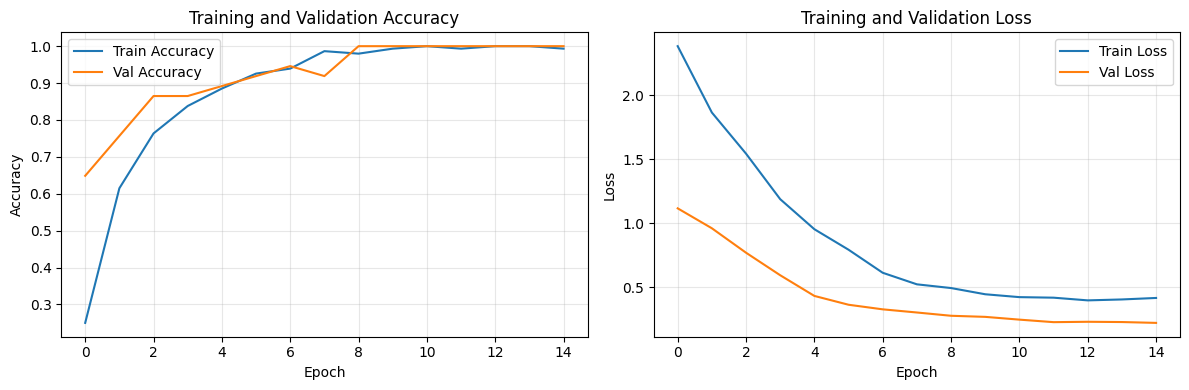

In [8]:
# ----------------------------
# TRAINING
# ----------------------------
print("\n" + "="*60)
print("TRAINING")
print("="*60)
OUTPUT_MODEL = "best_fatigue_model_all_levels_win30.keras"
# Callbacks
ckpt = callbacks.ModelCheckpoint(
    OUTPUT_MODEL,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)
rl = callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, verbose=1)
es = callbacks.EarlyStopping(
    patience=6,
    monitor="val_accuracy",
    restore_best_weights=True,
    verbose=1
)

# Training
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=40,
    batch_size=10,
    class_weight=class_weight,
    callbacks=[ckpt, rl, es],
    verbose=1
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


EVALUATION
Loaded best model from best_fatigue_model_all_levels_win30.keras

Validation Accuracy: 1.0000

Confusion Matrix:
[[ 9  0  0  0]
 [ 0 16  0  0]
 [ 0  0  8  0]
 [ 0  0  0  4]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     1.0000    1.0000    1.0000        16
           2     1.0000    1.0000    1.0000         8
           3     1.0000    1.0000    1.0000         4

    accuracy                         1.0000        37
   macro avg     1.0000    1.0000    1.0000        37
weighted avg     1.0000    1.0000    1.0000        37



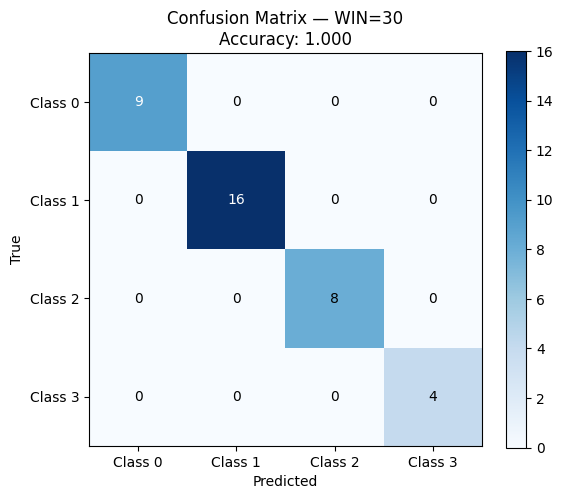


Per-class accuracy:
  Class 0: 1.000 (9 samples)
  Class 1: 1.000 (16 samples)
  Class 2: 1.000 (8 samples)
  Class 3: 1.000 (4 samples)


In [9]:
# ----------------------------
# EVALUATION
# ----------------------------
print("\n" + "="*60)
print("EVALUATION")
print("="*60)

# Load best model
try:
    model = tf.keras.models.load_model(OUTPUT_MODEL)
    print(f"Loaded best model from {OUTPUT_MODEL}")
except:
    print("Using current model (best checkpoint not found)")

# Predictions
proba = model.predict(X_val, verbose=0)
y_pred = np.argmax(proba, axis=1)

# Metrics
val_accuracy = (y_pred == y_val).mean()
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_val, y_pred, digits=4))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues", interpolation='nearest')
plt.title(f"Confusion Matrix — WIN={WIN}\nAccuracy: {val_accuracy:.3f}")
plt.colorbar()

# Add labels
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [f"Class {i}" for i in range(num_classes)])
plt.yticks(tick_marks, [f"Class {i}" for i in range(num_classes)])

# Add text annotations
thresh = cm.max() / 2
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-class accuracy:")
for class_idx in range(num_classes):
    class_mask = (y_val == class_idx)
    if np.sum(class_mask) > 0:
        class_acc = (y_pred[class_mask] == y_val[class_mask]).mean()
        print(f"  Class {class_idx}: {class_acc:.3f} ({np.sum(class_mask)} samples)")


PERMUTATION IMPORTANCE (Alternative Implementation)
Running permutation importance on 30 samples...
Baseline accuracy: 1.0000
Processing feature 21/21: HRR_percent

Top 10 Features by Permutation Importance:
    feature  perm_importance  perm_std
     ay_std         0.077778  0.015713
      rr_ms         0.055556  0.015713
HRR_percent         0.055556  0.015713
    az_mean         0.044444  0.015713
     ax_std         0.022222  0.015713
  gy_median         0.022222  0.015713
  gz_median         0.011111  0.015713
  gx_median         0.011111  0.015713
    gy_mean         0.011111  0.015713
    ay_mean         0.000000  0.000000


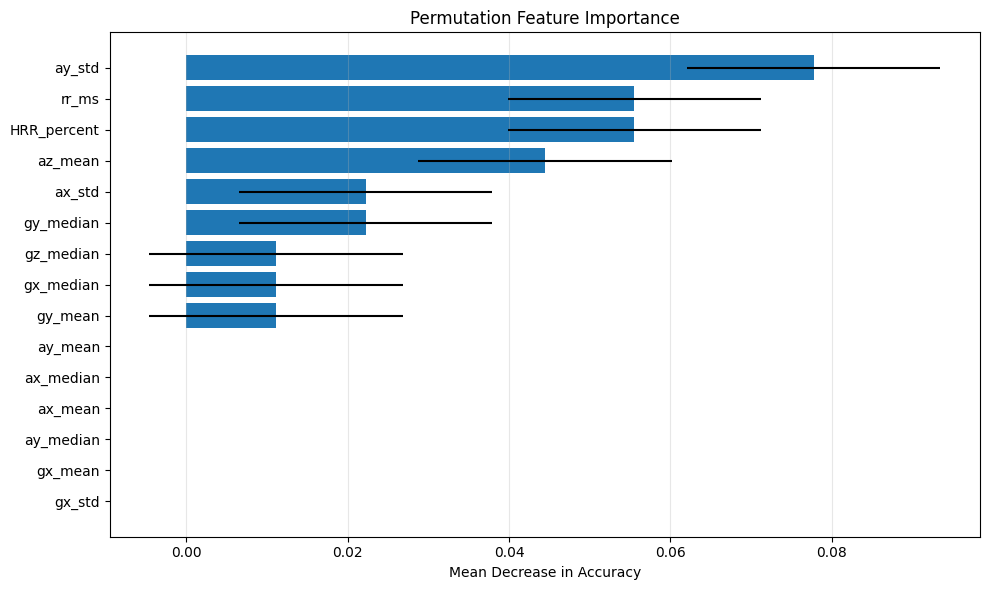


Permutation importance results saved to 'permutation_importance.csv'


In [10]:
# ----------------------------
# OPTIONAL: Proper Permutation Importance
# ----------------------------
print("\n" + "="*60)
print("PERMUTATION IMPORTANCE (Alternative Implementation)")
print("="*60)

def custom_permutation_importance(model, X, y, feature_names, n_repeats=5, random_state=42):
    """
    Custom implementation of permutation importance for Keras models
    """

    from sklearn.metrics import accuracy_score
    import numpy as np

    # Baseline accuracy
    y_pred = np.argmax(model.predict(X, verbose=0), axis=1)
    baseline_acc = accuracy_score(y, y_pred)

    print(f"Baseline accuracy: {baseline_acc:.4f}")

    # Initialize importance arrays
    importances = np.zeros(len(feature_names))
    importances_std = np.zeros(len(feature_names))

    # For each feature
    for feat_idx, feat_name in enumerate(feature_names):
        print(f"\rProcessing feature {feat_idx+1}/{len(feature_names)}: {feat_name}", end="")

        # Store scores for this feature
        feature_scores = []

        for repeat in range(n_repeats):
            # Create shuffled copy
            X_shuffled = X.copy()

            # Shuffle this feature across all samples and timesteps
            original_shape = X_shuffled[:, :, feat_idx].shape
            flattened = X_shuffled[:, :, feat_idx].flatten()

            # Permute
            rng = np.random.RandomState(random_state + repeat)
            permuted = rng.permutation(flattened)
            X_shuffled[:, :, feat_idx] = permuted.reshape(original_shape)

            # Compute accuracy with shuffled feature
            y_pred_shuffled = np.argmax(model.predict(X_shuffled, verbose=0), axis=1)
            shuffled_acc = accuracy_score(y, y_pred_shuffled)

            # Importance = decrease in accuracy
            feature_scores.append(baseline_acc - shuffled_acc)

        # Store mean and std
        importances[feat_idx] = np.mean(feature_scores)
        importances_std[feat_idx] = np.std(feature_scores)

    print()  # New line after progress

    # Create results dataframe
    perm_df = pd.DataFrame({
        'feature': feature_names,
        'perm_importance': importances,
        'perm_std': importances_std
    }).sort_values('perm_importance', ascending=False)

    return perm_df

# Run permutation importance on a subset
n_samples_perm = min(30, len(X_val))
sample_indices_perm = np.random.choice(len(X_val), n_samples_perm, replace=False)
X_perm = X_val[sample_indices_perm]
y_perm = y_val[sample_indices_perm]

print(f"Running permutation importance on {n_samples_perm} samples...")
perm_results = custom_permutation_importance(
    model, X_perm, y_perm, FEATURE_COLUMNS, n_repeats=3
)

print("\nTop 10 Features by Permutation Importance:")
print(perm_results.head(10).to_string(index=False))

# Plot permutation importance
plt.figure(figsize=(10, 6))
top_n = min(15, len(perm_results))
bars = plt.barh(range(top_n), perm_results['perm_importance'].head(top_n)[::-1],
               xerr=perm_results['perm_std'].head(top_n)[::-1])
plt.yticks(range(top_n), perm_results['feature'].head(top_n)[::-1])
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Permutation Feature Importance')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Save permutation results
perm_results.to_csv('permutation_importance.csv', index=False)
print("\nPermutation importance results saved to 'permutation_importance.csv'")

Available training samples: 148
Available validation samples: 37

Using 30 samples as background data
Using 20 samples for SHAP calculation

Background data shape: (30, 30, 21)
Sample data shape: (20, 30, 21)

Flattened sample data shape: (20, 630)
Flattened background data shape: (30, 630)

Creating KernelExplainer...
Calculating SHAP values (this may take a few minutes)...


  0%|          | 0/20 [00:00<?, ?it/s]


SHAP values calculated. Type: <class 'numpy.ndarray'>
Single array output: shape = (20, 630, 4)
Number of classes detected: 4

Final SHAP values shape: (4, 20, 30, 21)

Sample predictions accuracy: 0.950

GLOBAL FEATURE IMPORTANCE ANALYSIS
Multi-class analysis: 4 classes

Total features analyzed: 21
Top 20 Most Important Features:
    feature   importance
     ay_std 5.233233e+11
    ay_mean 5.233233e+11
  ax_median 1.397962e-03
    average 1.096092e-03
  gz_median 8.811246e-04
    az_mean 8.226156e-04
    ax_mean 7.890805e-04
    gz_mean 7.820716e-04
     gx_std 7.604963e-04
HRR_percent 7.526619e-04
  gy_median 7.128743e-04
     az_std 7.062460e-04
  ay_median 7.057446e-04
      rr_ms 6.876532e-04
    gy_mean 6.341031e-04
     gy_std 5.682933e-04
  gx_median 3.887629e-04
     ax_std 3.642994e-04
  az_median 3.220821e-04
     gz_std 3.096296e-04


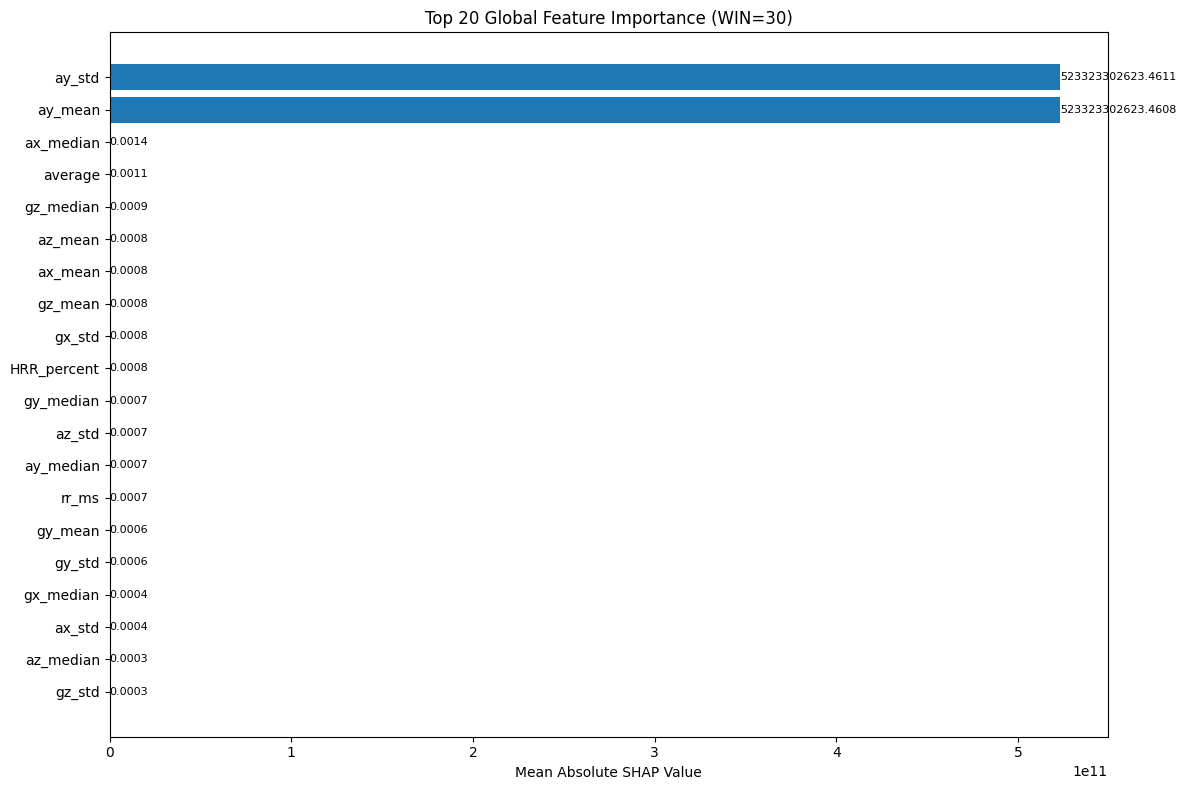


CLASS-SPECIFIC FEATURE IMPORTANCE

Class 0 - Top 10 features:
    feature  importance
    average    0.002333
  ax_median    0.001660
    gz_mean    0.001344
  ay_median    0.001308
    az_mean    0.000981
  gz_median    0.000956
     gx_std    0.000943
HRR_percent    0.000773
     gy_std    0.000755
      rr_ms    0.000722

Class 1 - Top 10 features:
    feature  importance
  ax_median    0.001818
  gz_median    0.001633
  gy_median    0.001622
    ax_mean    0.001601
    average    0.001434
     ay_std    0.001426
    gy_mean    0.001381
    az_mean    0.001300
    gz_mean    0.001140
HRR_percent    0.001117

Class 2 - Top 10 features:
    feature  importance
  ax_median    0.001620
      rr_ms    0.001261
     gx_std    0.001112
HRR_percent    0.001036
    gy_mean    0.000964
    ax_mean    0.000863
     az_std    0.000833
     ay_std    0.000764
     gy_std    0.000715
    az_mean    0.000706

Class 3 - Top 10 features:
  feature   importance
  ay_mean 2.093293e+12
   ay_std 2.093

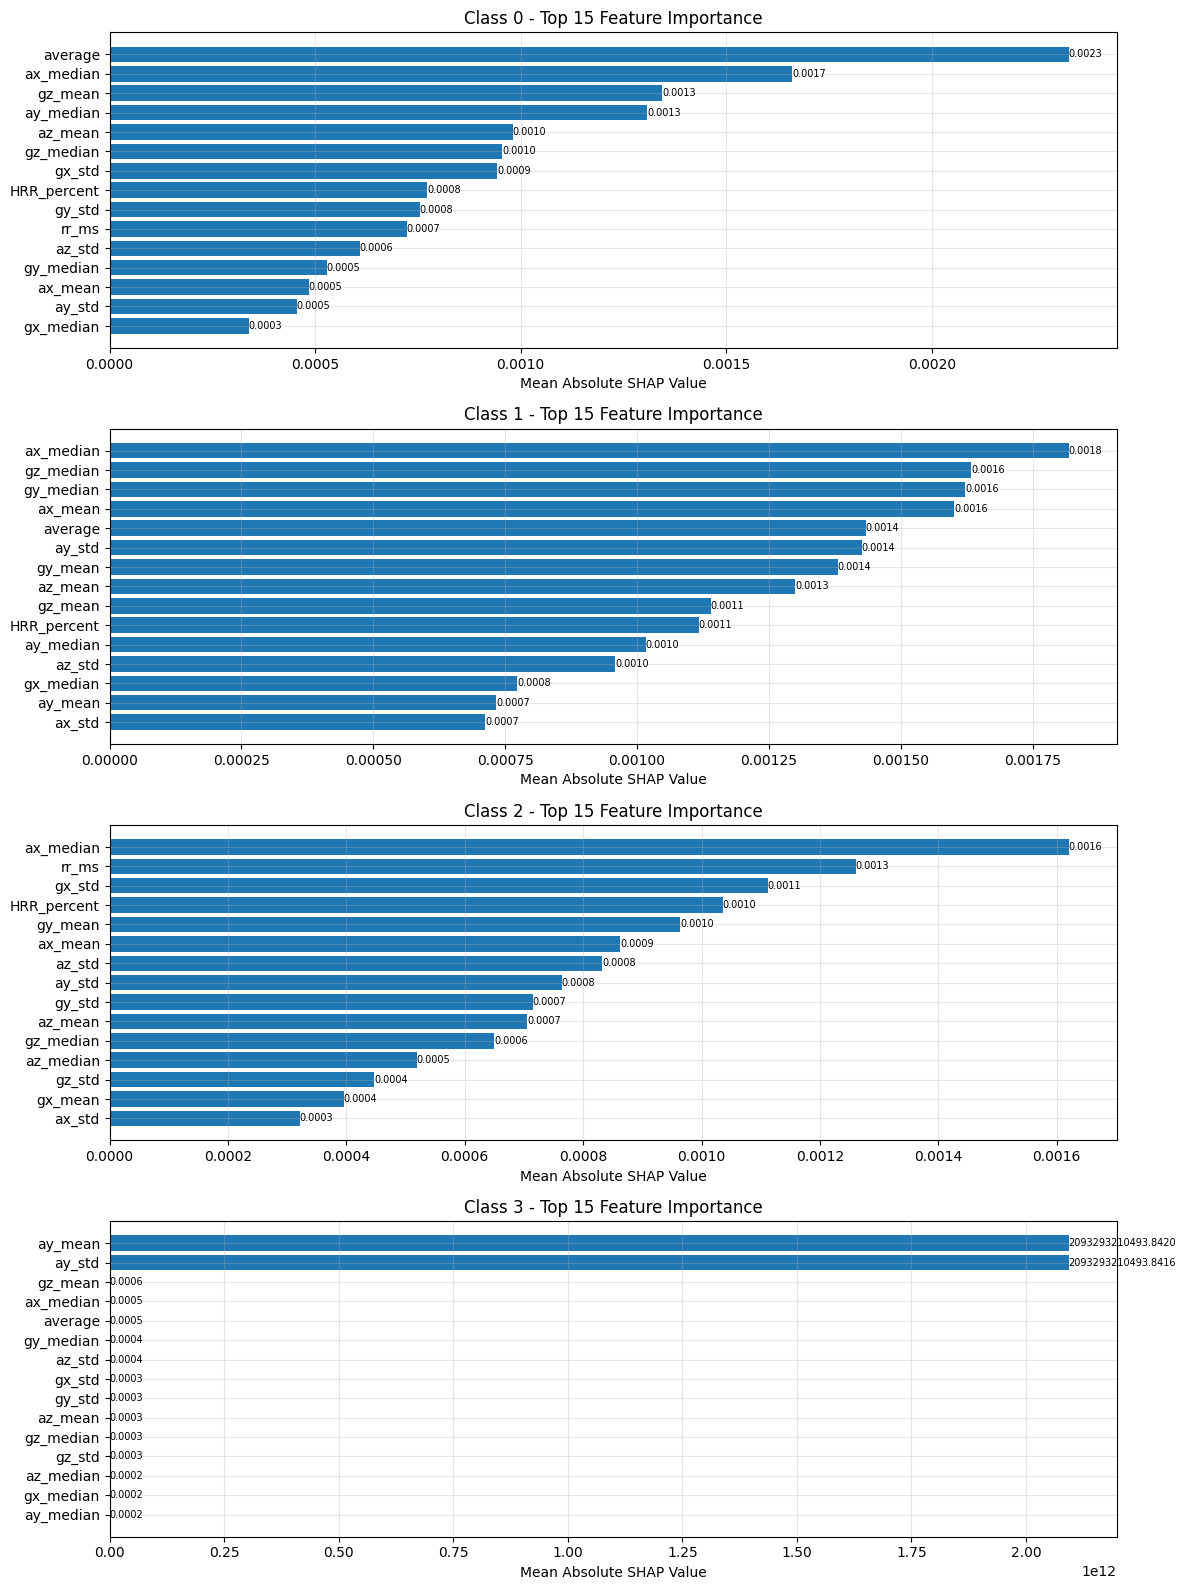


TEMPORAL IMPORTANCE ANALYSIS
Using multi-class temporal importance calculation

Most important timesteps (0-indexed): [ 7  1  0 18  2]
Corresponding importance values: [1.25171111e-03 1.80915870e-03 2.21488838e-03 7.47604718e+11
 7.47604718e+11]


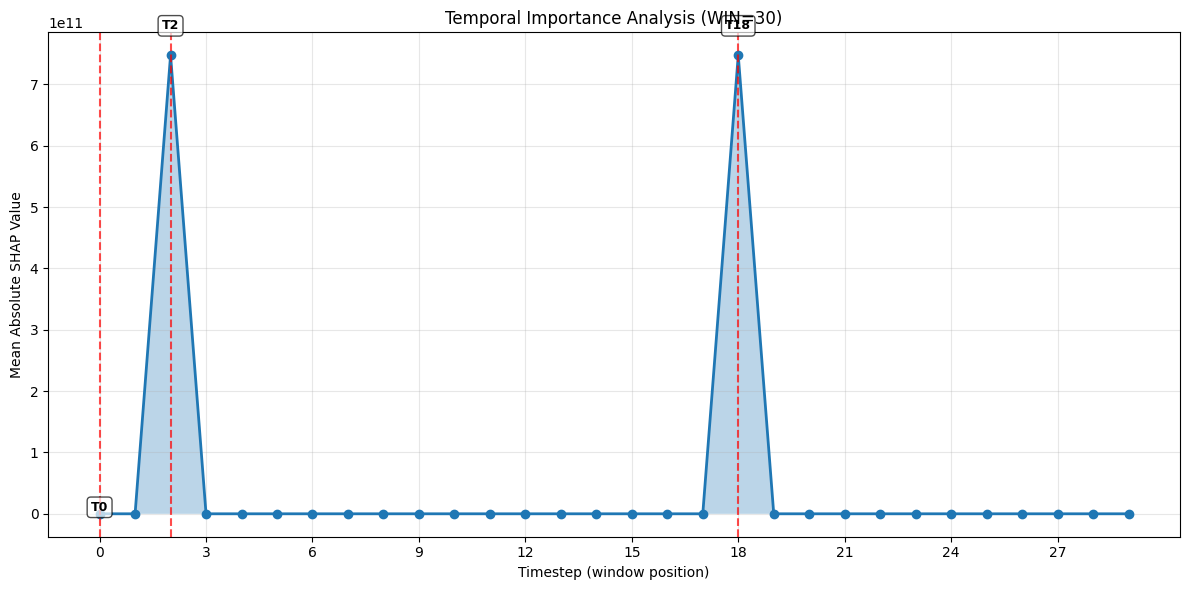


FEATURE IMPORTANCE SUMMARY


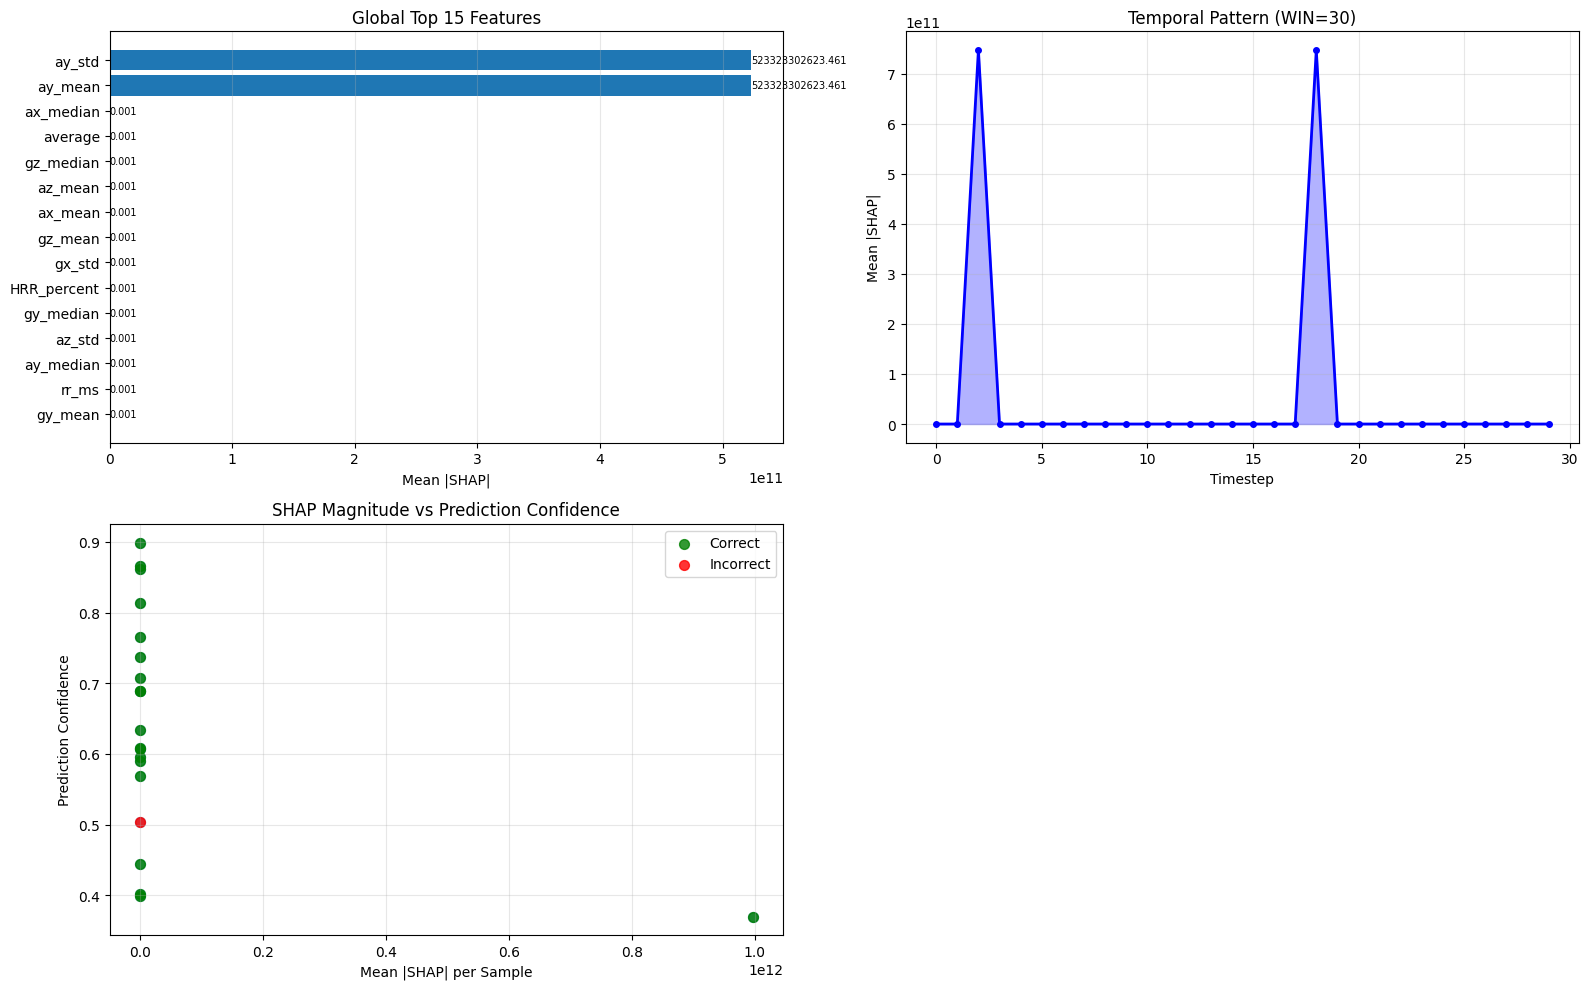


ANALYSIS COMPLETE!

Saving results...

Summary statistics:
- Number of features analyzed: 21
- Window size: 30
- Samples analyzed: 20
- Background samples: 30
- Most important feature: ay_std (523323302623.4611)
- Least important feature: gx_mean (0.0003)
- Importance ratio (most/least): 1901710475983322.50x

Additional insights:
1. Top 3 features account for 100.0% of total importance
2. Bottom 3 features account for 0.0% of total importance
3. Most important timestep: 2 with importance 747604718033.5165
4. Least important timestep: 24 with importance 0.0001

Configuration saved to shap_config.csv


In [ ]:
# ----------------------------
# SHAP Feature Importance Analysis using KernelExplainer
# ----------------------------


# Load the best saved model
model = tf.keras.models.load_model("best_fatigue_model_all_levels_win30.keras")

# Create a wrapper function for the model
def model_predict(X):
    """Wrapper function for model prediction"""
    # If X is 2D (samples × flattened features), reshape to 3D
    if len(X.shape) == 2:
        X = X.reshape(-1, WIN, len(FEATURE_COLUMNS))
    return model.predict(X, verbose=0)

# Check available data sizes
print(f"Available training samples: {len(X_train)}")
print(f"Available validation samples: {len(X_val)}")

# Prepare data for SHAP (use smaller subset)
# Adjust sizes based on available data
background_size = min(30, len(X_train))  # Reduced for speed
sample_size = min(20, len(X_val))  # Reduced for speed

print(f"\nUsing {background_size} samples as background data")
print(f"Using {sample_size} samples for SHAP calculation")

# Select background and sample data
background_indices = np.random.choice(len(X_train), background_size, replace=False)
background_data = X_train[background_indices]

sample_indices = np.random.choice(len(X_val), sample_size, replace=False)
X_sample = X_val[sample_indices]
y_true_sample = y_val[sample_indices]

print(f"\nBackground data shape: {background_data.shape}")
print(f"Sample data shape: {X_sample.shape}")

# Flatten the data for KernelExplainer (samples × (WIN * features))
X_sample_flat = X_sample.reshape(sample_size, -1)
background_data_flat = background_data.reshape(background_size, -1)

print(f"\nFlattened sample data shape: {X_sample_flat.shape}")
print(f"Flattened background data shape: {background_data_flat.shape}")

# Create explainer
print("\nCreating KernelExplainer...")
explainer = shap.KernelExplainer(model_predict, background_data_flat)

# Calculate SHAP values (this may take some time)
print("Calculating SHAP values (this may take a few minutes)...")
shap_values = explainer.shap_values(X_sample_flat, nsamples=50)  # Reduced nsamples for speed

print(f"\nSHAP values calculated. Type: {type(shap_values)}")

# Handle different SHAP output formats
if isinstance(shap_values, list):
    print(f"Multi-class output: list of {len(shap_values)} arrays")
    for i, sv in enumerate(shap_values):
        print(f"  Class {i}: shape = {sv.shape}")

    # For multi-class: each element in list has shape (samples, flattened_features)
    num_classes = len(shap_values)
    shap_values_3d_list = []

    for class_idx in range(num_classes):
        # Reshape to (samples, WIN, features) for each class
        class_shap_3d = shap_values[class_idx].reshape(sample_size, WIN, len(FEATURE_COLUMNS))
        shap_values_3d_list.append(class_shap_3d)

    # Convert to numpy array: shape (num_classes, samples, WIN, features)
    shap_values_3d = np.array(shap_values_3d_list)

else:
    print(f"Single array output: shape = {shap_values.shape}")

    # Check the shape to understand the format
    if len(shap_values.shape) == 3:
        # Shape is (samples, flattened_features, num_classes)
        num_classes = shap_values.shape[2]
        print(f"Number of classes detected: {num_classes}")

        # Reshape for each class
        shap_values_3d_list = []
        for class_idx in range(num_classes):
            # Extract SHAP values for this class and reshape
            class_shap = shap_values[:, :, class_idx]  # Shape: (samples, flattened_features)
            class_shap_3d = class_shap.reshape(sample_size, WIN, len(FEATURE_COLUMNS))
            shap_values_3d_list.append(class_shap_3d)

        shap_values_3d = np.array(shap_values_3d_list)
    else:
        # Assume binary classification with shape (samples, flattened_features)
        print("Assuming binary classification")
        shap_values_3d = shap_values.reshape(sample_size, WIN, len(FEATURE_COLUMNS))

print(f"\nFinal SHAP values shape: {shap_values_3d.shape}")

# Get predictions for the sample
y_pred_sample = np.argmax(model.predict(X_sample, verbose=0), axis=1)
print(f"\nSample predictions accuracy: {np.mean(y_pred_sample == y_true_sample):.3f}")

# ----------------------------
# 1. Global Feature Importance (across all timesteps and classes)
# ----------------------------
print("\n" + "="*60)
print("GLOBAL FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Calculate global importance based on SHAP values
if len(shap_values_3d.shape) == 4:  # Multi-class: (n_classes, n_samples, win, n_features)
    print(f"Multi-class analysis: {shap_values_3d.shape[0]} classes")
    global_importance = np.mean(np.abs(shap_values_3d), axis=(0, 1, 2))
else:  # Binary: (n_samples, win, n_features)
    print("Binary classification analysis")
    global_importance = np.mean(np.abs(shap_values_3d), axis=(0, 1))

feature_names = FEATURE_COLUMNS

# Create DataFrame for global importance
global_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': global_importance
}).sort_values('importance', ascending=False)

print(f"\nTotal features analyzed: {len(feature_names)}")
print(f"Top 20 Most Important Features:")
print(global_importance_df.head(20).to_string(index=False))

# Plot global feature importance
plt.figure(figsize=(12, 8))
top_n = min(20, len(global_importance_df))
bars = plt.barh(range(top_n), global_importance_df['importance'].head(top_n)[::-1])
plt.yticks(range(top_n), global_importance_df['feature'].head(top_n)[::-1])
plt.xlabel('Mean Absolute SHAP Value')
plt.title(f'Top {top_n} Global Feature Importance (WIN={WIN})')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# ----------------------------
# 2. Feature Importance per Class (for multi-class)
# ----------------------------
if len(shap_values_3d.shape) == 4:
    print("\n" + "="*60)
    print("CLASS-SPECIFIC FEATURE IMPORTANCE")
    print("="*60)

    num_classes = shap_values_3d.shape[0]
    fig, axes = plt.subplots(num_classes, 1, figsize=(12, 4*num_classes))
    if num_classes == 1:
        axes = [axes]

    for class_idx in range(num_classes):
        # Calculate importance for this class
        class_importance = np.mean(np.abs(shap_values_3d[class_idx]), axis=(0, 1))

        # Get top features for this class
        class_importance_df = pd.DataFrame({
            'feature': feature_names,
            f'importance': class_importance
        }).sort_values('importance', ascending=False)

        print(f"\nClass {class_idx} - Top 10 features:")
        print(class_importance_df.head(10).to_string(index=False))

        # Plot for this class
        ax = axes[class_idx]
        top_n_class = min(15, len(class_importance_df))
        bars = ax.barh(range(top_n_class), class_importance_df['importance'].head(top_n_class)[::-1])
        ax.set_yticks(range(top_n_class))
        ax.set_yticklabels(class_importance_df['feature'].head(top_n_class)[::-1])
        ax.set_xlabel('Mean Absolute SHAP Value')
        ax.set_title(f'Class {class_idx} - Top {top_n_class} Feature Importance')
        ax.grid(True, alpha=0.3)

        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f'{width:.4f}', ha='left', va='center', fontsize=7)

    plt.tight_layout()
    plt.show()

# ----------------------------
# 3. Temporal Importance Analysis
# ----------------------------
print("\n" + "="*60)
print("TEMPORAL IMPORTANCE ANALYSIS")
print("="*60)

# Calculate temporal importance
if len(shap_values_3d.shape) == 4:  # Multi-class
    temporal_importance = np.mean(np.abs(shap_values_3d), axis=(0, 1, 3))
    print("Using multi-class temporal importance calculation")
else:  # Binary
    temporal_importance = np.mean(np.abs(shap_values_3d), axis=(0, 2))
    print("Using binary temporal importance calculation")

# Find most important timesteps
important_timesteps = np.argsort(temporal_importance)[-5:]  # Top 5
print(f"\nMost important timesteps (0-indexed): {important_timesteps}")
print(f"Corresponding importance values: {temporal_importance[important_timesteps]}")

plt.figure(figsize=(12, 6))
plt.plot(range(WIN), temporal_importance, marker='o', linewidth=2, markersize=6)
plt.fill_between(range(WIN), 0, temporal_importance, alpha=0.3)
plt.xlabel('Timestep (window position)')
plt.ylabel('Mean Absolute SHAP Value')
plt.title(f'Temporal Importance Analysis (WIN={WIN})')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, WIN, max(1, WIN//10)))

# Highlight top 3 timesteps
top_3_timesteps = np.argsort(temporal_importance)[-3:]
for ts in top_3_timesteps:
    plt.axvline(x=ts, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    plt.text(ts, temporal_importance[ts] * 1.05, f'T{ts}',
             ha='center', va='bottom', fontweight='bold', fontsize=9,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()




# ----------------------------
# 3. Simplified Summary Visualization
# ----------------------------
print("\n" + "="*60)
print("FEATURE IMPORTANCE SUMMARY")
print("="*60)

# Create a comprehensive visualization
fig = plt.figure(figsize=(16, 10))

# 1. Global feature importance (top 15)
ax1 = plt.subplot(2, 2, 1)
top_global = global_importance_df.head(15)
bars1 = ax1.barh(range(len(top_global)), top_global['importance'][::-1])
ax1.set_yticks(range(len(top_global)))
ax1.set_yticklabels(top_global['feature'][::-1])
ax1.set_xlabel('Mean |SHAP|')
ax1.set_title('Global Top 15 Features')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}', ha='left', va='center', fontsize=7)

# 2. Temporal importance
ax2 = plt.subplot(2, 2, 2)
ax2.plot(range(WIN), temporal_importance, 'b-', linewidth=2, marker='o', markersize=4)
ax2.fill_between(range(WIN), 0, temporal_importance, alpha=0.3, color='blue')
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Mean |SHAP|')
ax2.set_title(f'Temporal Pattern (WIN={WIN})')
ax2.grid(True, alpha=0.3)



# 2. Correlation with prediction accuracy
ax4 = plt.subplot(2, 2, 3)
# Calculate prediction confidence
pred_proba = model.predict(X_sample, verbose=0)
pred_confidence = np.max(pred_proba, axis=1)

# Calculate mean SHAP magnitude per sample
if len(shap_values_3d.shape) == 4:
    sample_shap_magnitude = np.mean(np.abs(shap_values_3d), axis=(0, 2, 3))
else:
    sample_shap_magnitude = np.mean(np.abs(shap_values_3d), axis=(1, 2))

ax4.scatter(sample_shap_magnitude, pred_confidence, alpha=0.6, s=50)
ax4.set_xlabel('Mean |SHAP| per Sample')
ax4.set_ylabel('Prediction Confidence')
ax4.set_title('SHAP Magnitude vs Prediction Confidence')
ax4.grid(True, alpha=0.3)

# Color points by correctness
correct_mask = (y_pred_sample == y_true_sample)
ax4.scatter(sample_shap_magnitude[correct_mask], pred_confidence[correct_mask],
           alpha=0.8, s=50, label='Correct', color='green')
ax4.scatter(sample_shap_magnitude[~correct_mask], pred_confidence[~correct_mask],
           alpha=0.8, s=50, label='Incorrect', color='red')
ax4.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)

# Save results
print("\nSaving results...")
global_importance_df.to_csv('shap_feature_importance.csv', index=False)
np.save('shap_values_3d.npy', shap_values_3d)

print("\nSummary statistics:")
print(f"- Number of features analyzed: {len(feature_names)}")
print(f"- Window size: {WIN}")
print(f"- Samples analyzed: {sample_size}")
print(f"- Background samples: {background_size}")
print(f"- Most important feature: {global_importance_df.iloc[0]['feature']} ({global_importance_df.iloc[0]['importance']:.4f})")
print(f"- Least important feature: {global_importance_df.iloc[-1]['feature']} ({global_importance_df.iloc[-1]['importance']:.4f})")
print(f"- Importance ratio (most/least): {global_importance_df.iloc[0]['importance']/global_importance_df.iloc[-1]['importance']:.2f}x")

# Additional insights
print("\nAdditional insights:")
print(f"1. Top 3 features account for {global_importance_df.head(3)['importance'].sum()/global_importance_df['importance'].sum()*100:.1f}% of total importance")
print(f"2. Bottom 3 features account for {global_importance_df.tail(3)['importance'].sum()/global_importance_df['importance'].sum()*100:.1f}% of total importance")
print(f"3. Most important timestep: {np.argmax(temporal_importance)} with importance {np.max(temporal_importance):.4f}")
print(f"4. Least important timestep: {np.argmin(temporal_importance)} with importance {np.min(temporal_importance):.4f}")

# Save configuration
config_df = pd.DataFrame({
    'parameter': ['WIN', 'n_features', 'n_samples', 'n_background', 'n_classes'],
    'value': [WIN, len(feature_names), sample_size, background_size, num_classes if 'num_classes' in locals() else 1]
})
config_df.to_csv('shap_config.csv', index=False)
print("\nConfiguration saved to shap_config.csv")

In [11]:
best_model = tf.keras.models.load_model(
    "best_fatigue_model_all_levels_win30.keras"
)
best_model.save("best_fatigue_model_all_levels_win30.h5")

In [12]:


model = tf.keras.models.load_model(
    "best_fatigue_model_all_levels_win30.keras"
)